# Molecular Dynamics Simulation



### Molecular dynamics symulation utilizing Numba's JIT compiler. Speeds up computation by around 100X. 



In [1]:
import numpy as np
from time import time
from numba import jit, njit, prange

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from IPython.display import display, clear_output

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
%config InlineBackend.figure_format = 'retina'

In [2]:
def r_initial(N, L, η):
    n = int(np.sqrt(N)) # Number of particles along one edge
    σ0 = L/(n+1) # Lattice spacing
    r0 = np.array([np.array([(1+i%n), (1+int(i/n))]) for i in range(N)])*σ0 # Place particles on lattice
    rp = np.random.uniform(-1,1,(N,2))*η*σ0 # Randomly perturb the particle positions 
    return r0 + rp 


@njit
def scalar_distance(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    dist = (dx * dx + dy * dy) ** 0.5
    return dist

    
@njit(parallel = True) 
def compute_F_net(r, r0, F):
    for i in prange(len(r)-1):
        for j in range(i + 1, len(r)):
            rij_norm = scalar_distance(r[i], r[j])
            if rij_norm < r0:
                rij_hat = (r[j] - r[i]) / rij_norm
                fij = (24.0/rij_norm)*((2.0/rij_norm**12)-(1.0/rij_norm**6)) * rij_hat 
                # rij points from 1 to 2, so ...
                F[i] += - fij # - rij_hat direction
                F[j] +=   fij # + rij_hat direction
    return F
    
    
    
@njit
def compute_vnp(vn, ε):
    return np.sqrt(-(2/ε)*np.log(1-np.exp(-(1/2)*ε*np.abs(vn**2))))


@njit
def apply_boundary_conditions(r, v, L, ε):
    # Apply boundary conditions to each particle
    hit_left_wall = r[:, 0] <= 0
    hit_right_wall = r[:, 0] >= L 
    hit_bottom_wall = r[:, 1] <= 0
    hit_top_wall = r[:, 1] >=  L

    v[hit_left_wall, 0] = compute_vnp(v[hit_left_wall, 0], ε)
    v[hit_right_wall, 0] = - compute_vnp(v[hit_right_wall, 0], ε)
    v[hit_bottom_wall, 1] = compute_vnp(v[hit_bottom_wall, 1], ε)
    v[hit_top_wall, 1] = - compute_vnp(v[hit_top_wall, 1], ε)
    return v


@njit
def advance(r, v, F, Δt, L, r0, ε):

    ##### Apply boundary conditions #####
    v = apply_boundary_conditions(r, v, L, ε)

    ##### Advance particle positions #####
    r = r + Δt*v + 0.5*Δt**2*F 

    ##### Calculate new force vectors #####
    F0 = np.zeros_like(r)
    F_new = compute_F_net(r, r0, F=F0) 

    ##### Advance velocities #####
    v = v + 0.5*Δt*(F+F_new)
    F = F_new

    return r, v, F


@njit
def run_sim(r, v, F, Δt, L, r0, ε, N_iter, snapshots):
    for i in range(0,N_iter):
        
        r, v, F = advance(r, v, F, Δt, L, r0, ε)
        snapshots[i] = r
        
    return r, v, F, snapshots

*When running the simulation a second time it is around 10X faster than the first run*

In [6]:
N = 400
ε = 1
L = 20
η = 0.1
r0 = 3
Δt = 1e-3
N_iter = 4000


r = r_initial(N, L, η) 
v = np.zeros_like(r)
F = np.zeros_like(r)
F_zeros = np.zeros_like(F)
snapshot_arr = np.zeros((N_iter, r.shape[0], 2))


start = time()

r, v, F, snapshots_f = run_sim(r, v, F, Δt, L, r0, ε, N_iter, snapshot_arr)

end = time()
print("{} seconds".format(end-start))

7.105823040008545 seconds


In [7]:
def plot_iteration(r, t, L,  ax_size=15, p_size=1000, moving_avg=10):
    # Displays state of system
    Xc, Yc = L/2, L/2

    plt.cla()
    plt.clf()
    plt.close()
    plt.figure(figsize=(ax_size, ax_size))
    
    plt.title("Molecular Simulation \n t = {:.4f}".format(t), fontsize=20)
    
    plt.scatter(r[:,0], r[:,1], s=p_size, alpha=0.7)
    plt.xlim([-1, L+1])
    plt.ylim([-1, L+1])
    plt.axis("off")
    ax = plt.gca()
    ax.add_patch(patches.Rectangle(xy=(0, 0),  width=L, height=L, linewidth=2, color='red', fill=False))
    clear_output(wait=True)
    display(plt.gcf())
    

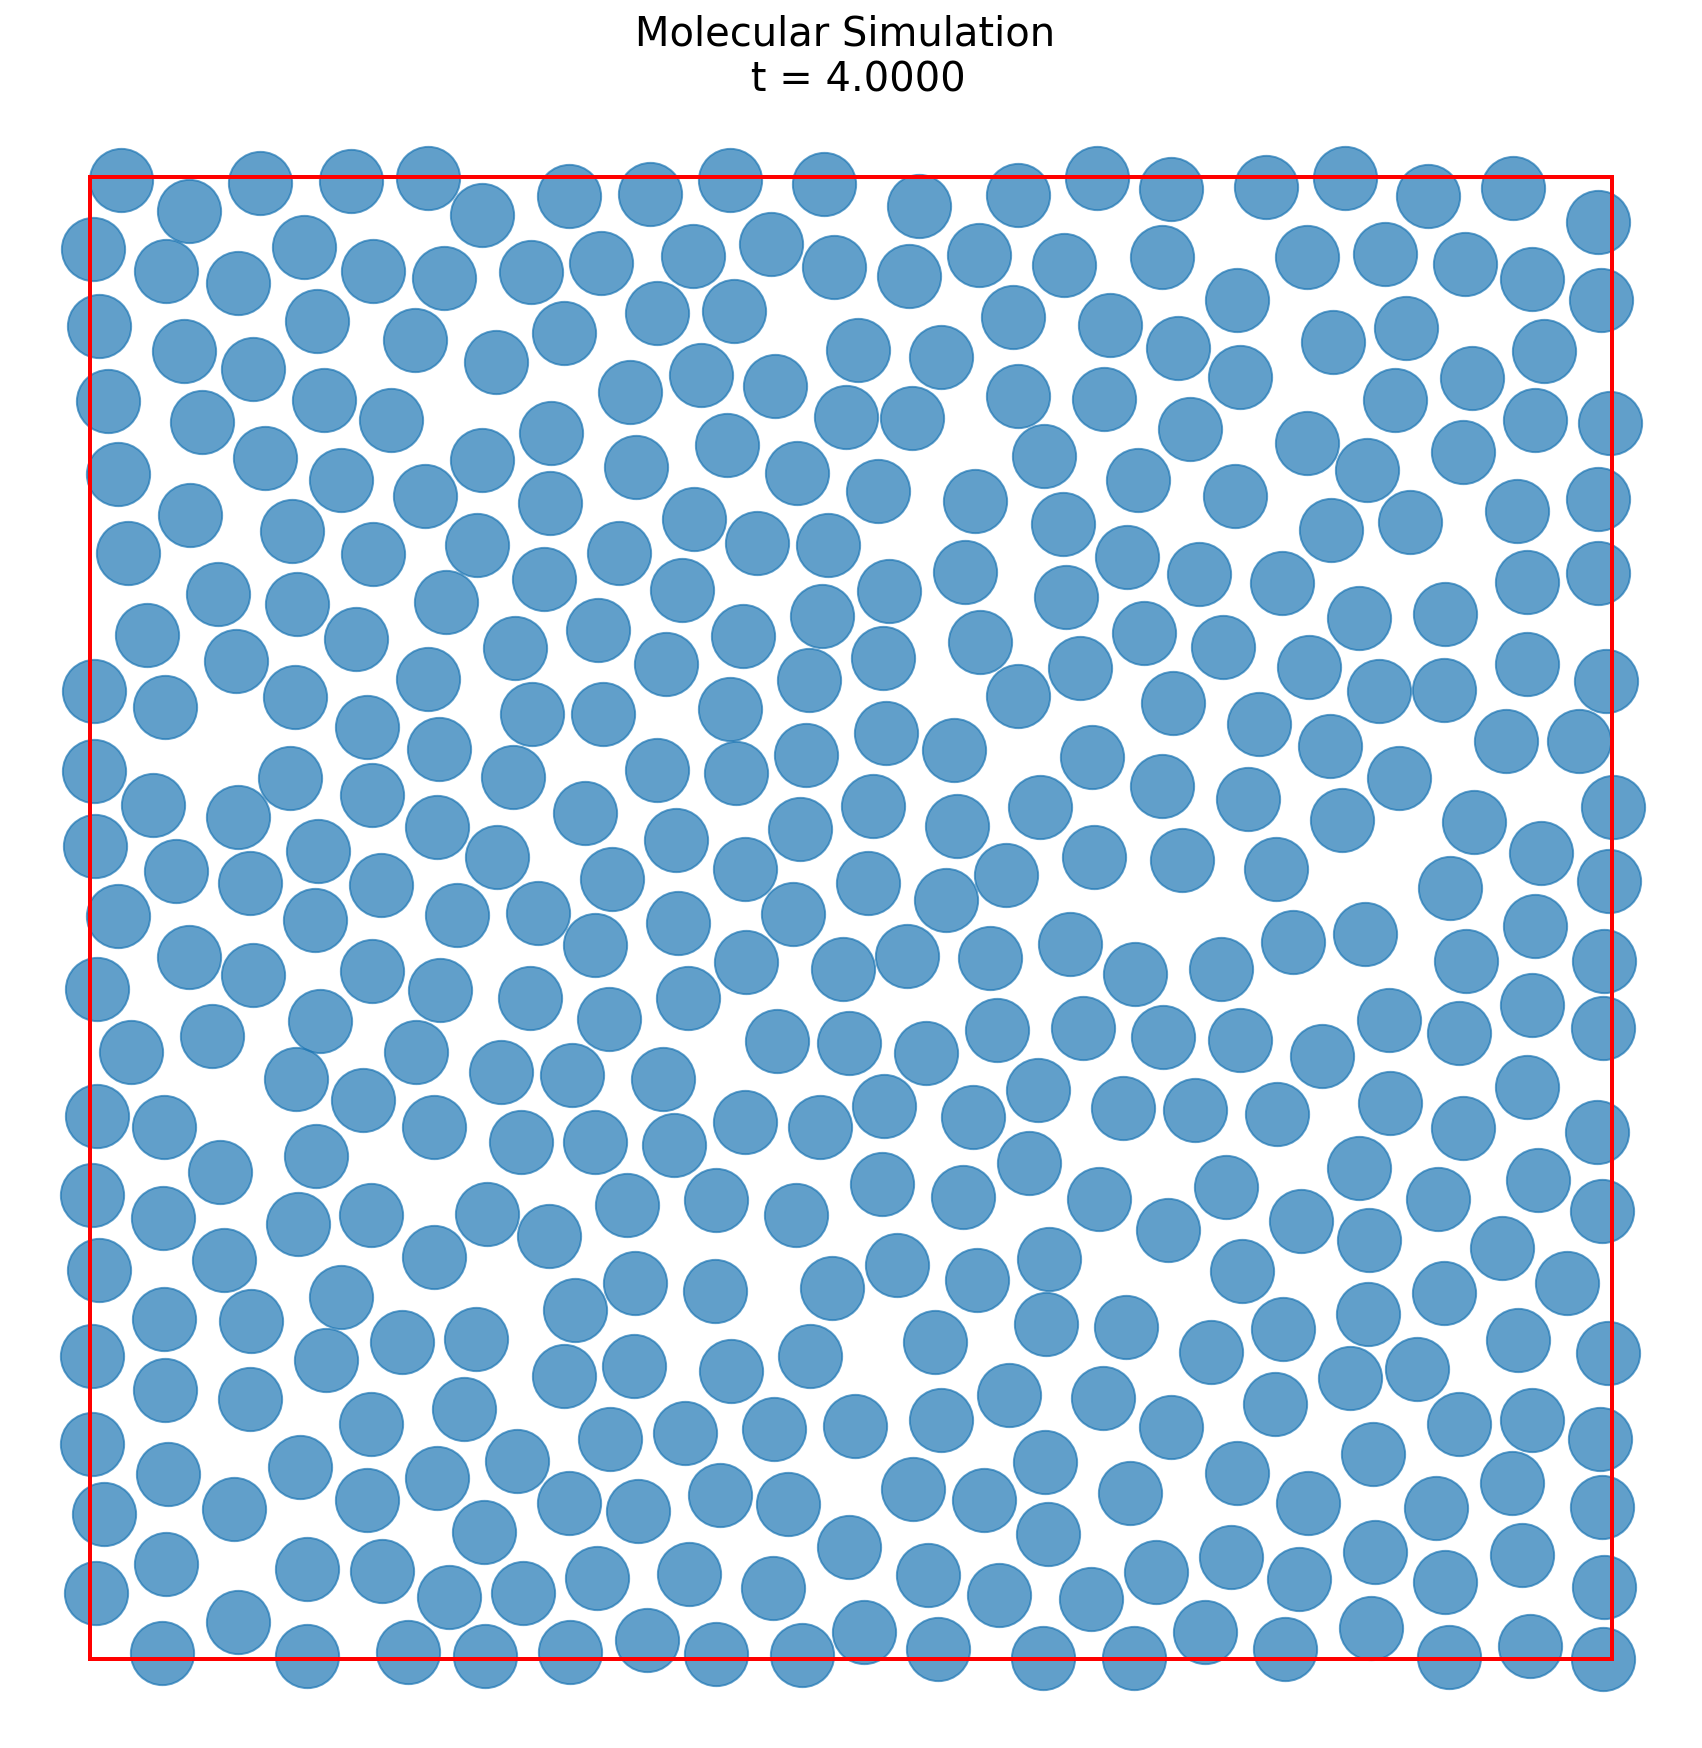

In [8]:
t = 0
for i in range(0,N_iter):
    t += Δt
    if (i % (10)) == 0:
        plot_iteration(snapshots_f[i], t, L)
        
plt.close()